# **SIIM COVID-19 EDA**

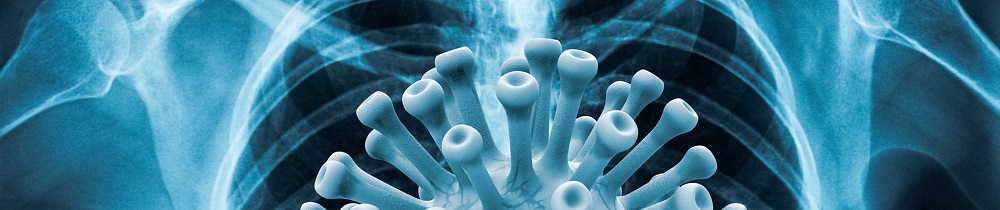

## Training and Inferance
- [SIIM COVID-19 Detectron2 Training](https://www.kaggle.com/ammarnassanalhajali/siim-covid-19-detectron2-training)
- [SIIM COVID-19 Detectron2 Inferance](https://www.kaggle.com/ammarnassanalhajali/siim-covid-19-detectron2-inferance)
- [COVID-19 Detection YOLOv5 3Classes [Training] ](https://www.kaggle.com/ammarnassanalhajali/covid-19-detection-yolov5-3classes-training)
- [COVID-19 Detection YOLOv5 3Classes [Inference]](https://www.kaggle.com/ammarnassanalhajali/covid-19-detection-yolov5-3classes-inference)
- [SIIM-COVID-19 Detection Training Labels (Dataset)](https://www.kaggle.com/ammarnassanalhajali/siimcovid19-detection-training-label)

### Please if this kernel is useful, <font color='red'>please upvote !!</font>

# Introduction 

* Currently, COVID-19 can be diagnosed via polymerase chain reaction to detect genetic material from the virus or chest radiograph. However, it can take a few hours and sometimes days before the molecular test results are back. By contrast, chest radiographs can be obtained in minutes.

* In this competition, we’ll identify and localize COVID-19 abnormalities on chest radiographs. In particular, we'll categorize the radiographs as negative for pneumonia or typical, indeterminate, or atypical for COVID-19. 

* In this competition, we hope to develop a model to help radiologists diagnose the millions of COVID-19 patients more confidently and quickly.


# Data & Files
* **Train folder**: The train dataset comprises 6,334 chest scans in DICOM format
* All images are stored in paths with the form **study**/**series**/**image**
    * **study**: The study ID here relates directly to the study-level predictions.
    *  **image**:The image ID is the ID used for image-level predictions.
* **Test folder**:The hidden test dataset is of roughly the same scale as the training dataset.
    

* **train_study_level.csv**: The train study-level metadata, with one row for each study, including correct labels.
* **train_image_level.csv**: The train image-level metadata, with one row for each image, including both correct labels and any bounding boxes in a dictionary format. Some images in both test and train have multiple bounding boxes.
* **sample_submission.csv**: A sample submission file containing all image- and study-level IDs.



# Columns
### train_study_level.csv

* **id**:unique study identifier
* **Negative for Pneumonia**:1 if the study is negative for pneumonia, 0 otherwise
* **Typical Appearance**:1 if the study has this appearance, 0 otherwise
* **Indeterminate Appearance**:1 if the study has this appearance, 0 otherwise
* **Atypical Appearance**:1 if the study has this appearance, 0 otherwise




1. **Normal chest X-ray(Negative)**. It is not uncommon for the chest X-ray to be normal early in the disease, so a normal X-ray does not rule out infection.
1. **Typical** findings or findings commonly associated with COVID-19 in the scientific literature (. These include a reticular pattern, ground-glass opacities and consolidations, with rounded morphology and a confluent or patchy multifocal distribution. The distribution is usually bilateral and peripheral, with a predominance in the lower fields . The differential diagnosis includes organising pneumonia, drug toxicity and other causes of acute lung damage. Between the first and third week from the onset of symptoms, typical X-ray findings may progress to diffuse disease. This is related to a severe clinical hypoxaemia situation, and the main differential diagnosis is acute respiratory distress syndrome (ARDS).
1. **Indeterminate** findings and findings that may present in cases of COVID-19 pneumonia can have other causes. These include consolidations and ground-glass opacities with a unilateral, central or upper-lobe distribution. The differential diagnosis includes other infections and alveolar oedema.
1. **Atypical** findings, uncommon findings or findings not reported in COVID-19 pneumonia. These include lobar consolidation, lung nodules or masses, miliary pattern, cavitation and pleural effusion, reported in only 3% of patients and more typical of advanced disease.


### train_image_level.csv

* **id**:unique image identifier
* **boxes**:bounding boxes in easily-readable dictionary format
* **label**:the correct prediction label for the provided bounding boxes

# Importing libraries

In [ ]:
!pip install gdcm

In [ ]:
import numpy as np 
import pandas as pd 
from pandas import DataFrame
from matplotlib.lines import Line2D
import plotly.express as px
import seaborn as sns
import os
import pydicom
import glob
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import warnings
from fastai.vision.all import *
from fastai.medical.imaging import *
warnings.filterwarnings('ignore')


# let's take trip around data

##  train_study_level.csv

In [ ]:
train_study_df = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
train_study_df = train_study_df.rename(columns = {'Negative for Pneumonia': 'Negative', 'Typical Appearance': 'Typical', 'Indeterminate Appearance': 'Indeterminate', 'Atypical Appearance': 'Atypical'}, inplace = False)
train_study_df.head(6)

In [ ]:
def bar_plot(df,x,x_title,y,title,colors=None,text=None):
    fig = px.bar(x=x,
                 y=y,
                 text=text,
                 labels={x: x_title.title()},   
                 data_frame=df,
                 color=colors,
                 barmode='group',
                 template="simple_white")
    
    texts = [df[col].values for col in y]
    for i, t in enumerate(texts):
        fig.data[i].text = t
        fig.data[i].textposition = 'inside'
        
    fig['layout'].title=title

    fig.update_layout(title_font_size=19)
    fig.update_layout(title_font_family='Droid Serif')
    fig.update_layout(width=800,height=500)
        


    for trace in fig.data:
        trace.name = trace.name.replace('_',' ').title()

    fig.update_yaxes(tickprefix="", showgrid=True)

    fig.show()

In [ ]:
train_study_df['label_y'] = 'Negative'
train_study_df.loc[train_study_df['Typical']==1, 'label_y'] = 'Typical'
train_study_df.loc[train_study_df['Indeterminate']==1, 'label_y'] = 'Indeterminate'
train_study_df.loc[train_study_df['Atypical']==1, 'label_y'] = 'Atypical'

train_study_df.head(5)

In [ ]:
train_study_df1=train_study_df.groupby(['label_y']).size().reset_index(name='counts')
train_study_df1

bar_plot(train_study_df1,
         'label_y',
         'target',
         ['counts'],
         title='Target')



## train_image_level.csv

In [ ]:
train_image_df = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')
train_image_df.head(2)

in **Label** Column, the format is as follows: `[class ID] [confidence score] [bounding box]`

* **Class ID**: Either opacity or none
* **Confidence score**: confidence from your neural network model. If none, the confidence is 1.
* **Bounding box**:typical xmin ymin xmax ymax format. If class ID is none, the bounding box is 1 0 0 1 1.

The bounding boxes are also provided in easily readable dictionary format in column **boxes**

In [ ]:
train_image_df['class'] = train_image_df.label.apply(lambda x: x.split()[0])
#train_image_df['class'].hist(FaceColor="#0066aa")
train_study_df2=train_image_df.groupby(['class']).size().reset_index(name='counts')
bar_plot(train_study_df2,
         'class',
         'class',
         ['counts'],
         title='Class')

In [ ]:
train_image_df['x_min'] = train_image_df.label.apply(lambda x: float(x.split()[2]))
train_image_df['y_min'] = train_image_df.label.apply(lambda x: float(x.split()[3]))
train_image_df['x_max'] = train_image_df.label.apply(lambda x: float(x.split()[4]))
train_image_df['y_max'] = train_image_df.label.apply(lambda x: float(x.split()[5]))
train_image_df.head(3).T

In [ ]:
train_study_df['StudyInstanceUID'] = train_study_df['id'].apply(lambda x: x.replace('_study', ''))
del train_study_df['id']
train_image_df = train_image_df.merge(train_study_df, on='StudyInstanceUID')
train_image_df.sample(3).T

In [ ]:

train_image_df['integer_label'] = train_image_df['label_y']
train_image_df.head(3).T

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_image_df['integer_label'])
train_image_df['integer_label']=le.transform(train_image_df['integer_label'])
train_image_df.head(3).T

In [ ]:
train_image_df['id_image'] = train_image_df['id']
train_image_df['id'] = train_image_df['id'].apply(lambda x: x.replace('_image', ''))
train_image_df.head(3).T

In [ ]:
train_image_df.to_csv("train_image_df.csv")


# Labels distribution 

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(18,15))
sns.kdeplot(train_image_df["Negative"], shade=True,ax=ax[0,0],color="#00ff00")
ax[0,0].set_title("Negative for Pneumonia Distribution",font="Serif", fontsize=15)
ax[0,0].set(xlabel=None)
sns.kdeplot(train_image_df["Typical"], shade=True,ax=ax[0,1],color="#4209ff")
ax[0,1].set_title("Typical Appearance Distribution",font="Serif", fontsize=15)
ax[0,1].set(xlabel=None)
sns.kdeplot(train_image_df["Indeterminate"], shade=True,ax=ax[1,0],color="#f72545")
ax[1,0].set_title("Indeterminate Appearance Distribution",font="Serif", fontsize=15)
ax[1,0].set(xlabel=None)
sns.kdeplot(train_image_df["Atypical"], shade=True,ax=ax[1,1],color="#FFBA08")
ax[1,1].set_title("Atypical Appearance Distribution",font="Serif", fontsize=15)
ax[1,1].set(xlabel=None)
plt.show()

# A look at the images

In [ ]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data
        
    
def plot_img(img, size=(5, 5), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


def plot_imgs(imgs, cols=4, size=5, is_rgb=True, title="", cmap='gray', img_size=(300,300)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

In [ ]:
dicom_paths = get_dicom_files('../input/siim-covid19-detection/train')
imgs = [dicom2array(path) for path in dicom_paths[-4:]]
plot_imgs(imgs)

In [ ]:
train_image_df = train_image_df[~train_image_df.boxes.isnull()] 
class_names = ['Typical', 'Indeterminate', 'Atypical'] # we have 3 positive classes
unique_classes = np.unique(train_image_df[class_names].values, axis=0)

# Plot images with bounding box

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

def custom_palette(custom_colors):
    customPalette = sns.set_palette(sns.color_palette(custom_colors))
    sns.palplot(sns.color_palette(custom_colors),size=0.5)
    plt.tick_params(axis='both', labelsize=0, length = 0)

palette = ["#4209ff","#f72545","#FFBA08"]
custom_palette(palette)


### <span style="color:#4209ff">Typical Appearance</span>
### <span style="color:#f72545">Indeterminate Appearance</span>
### <span style="color:#FFBA08">Atypical Appearance</span>

# All classes

In [ ]:
from glob import glob
imgs = []
label2color = {
    '[1, 0, 0]': [66,9,255], # Typical Appearance
    '[0, 1, 0]': [247,37,69], # Indeterminate Appearance
    '[0, 0, 1]': [255,186,8], # Atypical Appearance
}
thickness = 3
scale = 6

for _, row in train_image_df[train_image_df['Negative']==0].iloc[12:20].iterrows():
    study_id = row['StudyInstanceUID']
    img_path = glob(f'../input/siim-covid19-detection/train/{study_id}/*/*')[0]
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    bboxes = []
    bbox = []
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []    
    
    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (600,600))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)


# <span style="color:#4209ff">Typical Appearance</span>


In [ ]:
imgs = []

for _, row in train_image_df[train_image_df['Typical'] == 1].iloc[8:12].iterrows():
    study_id = row['StudyInstanceUID']
    img_path = glob(f'../input/siim-covid19-detection/train/{study_id}/*/*')[0]
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    bboxes = []
    bbox = []
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []    
    
    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (600,600))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)


# <span style="color:#f72545">Indeterminate Appearance</span>

In [ ]:
imgs = []

for _, row in train_image_df[train_image_df['Indeterminate'] == 1].iloc[2:6].iterrows():
    study_id = row['StudyInstanceUID']
    img_path = glob(f'../input/siim-covid19-detection/train/{study_id}/*/*')[0]
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    bboxes = []
    bbox = []
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []    
    
    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (600,600))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

# <span style="color:#FFBA08">Atypical Appearance</span>

In [ ]:
imgs = []

for _, row in train_image_df[train_image_df['Atypical'] == 1].iloc[0:4].iterrows():
    study_id = row['StudyInstanceUID']
    img_path = glob(f'../input/siim-covid19-detection/train/{study_id}/*/*')[0]
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    claz = row[class_names].values
    color = label2color[str(claz.tolist())]

    bboxes = []
    bbox = []
    for i, l in enumerate(row['label'].split(' ')):
        if (i % 6 == 0) | (i % 6 == 1):
            continue
        bbox.append(float(l)/scale)
        if i % 6 == 5:
            bboxes.append(bbox)
            bbox = []    
    
    for box in bboxes:
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (600,600))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

# More visualization

In [ ]:
train_image_df = pd.read_csv('./train_image_df.csv')

In [ ]:
train_image_df['x_mid'] = train_image_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_image_df['y_mid'] = train_image_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_image_df['w'] = train_image_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_image_df['h'] = train_image_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_image_df['area'] = train_image_df['w']*train_image_df['h']
train_image_df.head()

In [ ]:
features = ['x_min', 'y_min', 'x_max', 'y_max', 'x_mid', 'y_mid', 'w', 'h', 'area']
X = train_image_df[features]
y = train_image_df['integer_label']
X.shape, y.shape

In [ ]:
class_ids, class_names = list(zip(*set(zip(train_image_df.integer_label, train_image_df.label_y))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

# t-SNE Visualization
t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In [ ]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 40, random_state=1, n_iter=50000)
data_X = X
data_y = y.loc[data_X.index]
embs = tsne.fit_transform(data_X)
# Add to dataframe for convenience
plot_x = embs[:, 0]
plot_y = embs[:, 1]

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
plt.axis('off')
scatter = plt.scatter(plot_x, plot_y, marker = 'o',s = 50, c=data_y.tolist(), alpha= 0.5,cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

# BBox Location
## x_mid Vs y_mid


In [ ]:
from scipy.stats import gaussian_kde


x_val = train_image_df.x_mid.values
y_val = train_image_df.y_mid.values

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# ax.set_xlabel('x_mid')
# ax.set_ylabel('y_mid')
plt.show()

## bbox_w Vs bbox_h


In [ ]:
x_val = train_image_df.w.values
y_val = train_image_df.h.values

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# ax.set_xlabel('bbox_width')
# ax.set_ylabel('bbox_height')
plt.show()

# Image Aspect Ratio

In [ ]:

train_image_df1 = pd.read_csv('../input/siim-covid19-resized-1024px/meta.csv')

x_val = train_image_df1.dim0.values
y_val = train_image_df1.dim1.values

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# ax.set_xlabel('image_width')
# ax.set_ylabel('image_height')
plt.show()

### If you like my work, please upvote

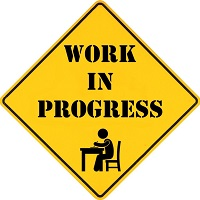

# References
1. https://www.kaggle.com/tanlikesmath/siim-covid-19-detection-a-simple-eda
1. https://www.kaggle.com/yujiariyasu/plot-3positive-classes
1. https://www.kaggle.com/ruchi798/siim-covid-19-detection-eda-data-augmentation
1. Chamorro, E. Martínez, A. Díez Tascón, L. Ibáñez Sanz, S. Ossaba Vélez, and S. Borruel Nacenta. "Radiologic diagnosis of patients with COVID-19." Radiología (English Edi-tion) 63, no. 1 (2021): 56-73.
